In [102]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
import keras.backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
import math


In [103]:
category_count=10 #Number of digit categories

(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

print('Train data flatten shape: ',train_x.shape)
print('Train label shape: ',train_y.shape)
print('Test data flatten shape: ',test_x.shape)
print('Test label shape: ',test_y.shape)

Train data flatten shape:  (60000, 28, 28)
Train label shape:  (60000,)
Test data flatten shape:  (10000, 28, 28)
Test label shape:  (10000,)


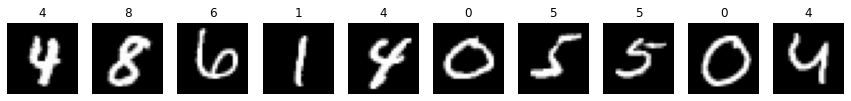

In [104]:
image_count=10

_, axs = plt.subplots(1, image_count,figsize=(15, 10))
for i in range(image_count):
  random_idx=random.randint(0,train_x.shape[0])
  axs[i].imshow(train_x[random_idx],cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(train_y[random_idx])

In [105]:
val_size=10000

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = val_size,random_state = 1,shuffle=True)

print('Train data flatten shape: ',train_x.shape)
print('Train label shape: ',train_y.shape)
print('Validation data flatten shape: ',val_x.shape)
print('Validation label shape: ',val_y.shape)

Train data flatten shape:  (50000, 28, 28)
Train label shape:  (50000,)
Validation data flatten shape:  (10000, 28, 28)
Validation label shape:  (10000,)


In [106]:
if len(train_x.shape) == 3:
    train_x = np.expand_dims(train_x, axis=3)
    test_x = np.expand_dims(test_x, axis=3)
    val_x = np.expand_dims(val_x, axis=3)

print('Train shape: ',train_x.shape)
print('Test shape: ',test_x.shape)

Train shape:  (50000, 28, 28, 1)
Test shape:  (10000, 28, 28, 1)


In [107]:

train_x = train_x/255.0
val_x = val_x/255.0
test_x = test_x/255.0

print('Min value: ',train_x.min())
print('Max value: ',train_x.max())

Min value:  0.0
Max value:  1.0


In [108]:
if train_x.shape[2] == 1:
    train_x = (train_x * 2) - 1
    val_x = (val_x * 2) - 1
    test_x = (test_x * 2) -1
    print('Min value: ',train_x.min())
    print('Max value: ',train_x.max())

In [109]:
def sampling(z_mean, z_log_var, input_label):
    """Reparameterization trick. Instead of sampling from Q(z|X), 
    sample eps = N(0,I) z = z_mean + sqrt(var)*eps.

    Parameters:
    -----------
    args: list of Tensors
        Mean and log of variance of Q(z|X)

    Returns
    -------
    z: Tensor
        Sampled latent vector
    """
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    z_cond = tf.concat([z, input_label], axis=1) # (batch_size, label_dim + latent_dim)
    return z_cond

In [110]:
def encoder_CVAE( input_shape = (32, 32, 3),  label_size=2, latent_dim = 2): 

    inputs = layers.Input(shape=(input_shape[0],
            input_shape[1], input_shape[2] + label_size), dtype='float32',name='Input')
    #inputs = layers.Input(shape = input_shape)
    #labels_inputs = layers.Input(shape = (50, 50, 2))
    #encoder_inputs = layers.Concatenate()([inputs, labels_inputs])


    #block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(inputs)

    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    
    # block 2
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S4')(x)
    
    x = layers.BatchNormalization()(x)
    
    # block 3
    x = layers.Conv2D(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(16, (3, 3),
                activation='relu',
                padding='same',
                name='block3_conv2')(x)    
                    
    x = layers.Conv2D(filters=5, kernel_size=5,strides=1,padding='same')(x)
    x = layers.Flatten()(x)
    y = layers.Dense(latent_dim * 2)(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(y)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(y)
    #z_cond = layers.Lambda(sampling, name='z')([z_mean, z_log_var, input_label]) #reparametrization trick
    model = keras.Model(inputs, [z_mean, z_log_var], name='encoder')
    
    return model
    

In [111]:
def decoder_CVAE(latent_dim = 2,label_size=2): 

    decoder_inputs = layers.Input(shape=(latent_dim + label_size,) , name='decoder_input')
    x = layers.Dense(14*14*1)(decoder_inputs) # if latent_dim < 25*25*3
    x = layers.Reshape(target_shape=(14, 14, 1))(x)
    x = layers.Conv2DTranspose(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block4_conv1')(x)
    x = layers.Conv2DTranspose(16, (3, 3),
                    activation='relu',
                    padding='same',
                    name='up_block4_conv2')(x)  
    
    # block 2
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv1')(x)
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv2')(x)
    x = layers.UpSampling2D()(x)
    
    
    x = layers.Conv2DTranspose(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block6_conv1')(x)

    x = layers.Conv2DTranspose(64, (3, 3),
                    activation='relu',
                    padding='same',
                    name='up_block6_conv2')(x)
                      
                      
    outputs = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, activation='sigmoid',padding='same')(x)
   # outputs = layers.Reshape(target_shape=(50, 50, 3), name='output')(x)
    model = keras.Model(decoder_inputs, outputs, name='decoder')
    return model

In [112]:
cvae_encoder = encoder_CVAE(input_shape = (28, 28, 1), latent_dim = 2, label_size=category_count)
cvae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 28, 28, 11)  0           []                               
                                ]                                                                 
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   6400        ['Input[0][0]']                  
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block2_conv1 (Conv2D)          (None, 28, 28, 32)   18464       ['block1_conv2[0][0]']     

In [113]:
cvae_decoder = decoder_CVAE(latent_dim = 2, label_size = category_count)
cvae_decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 12)]              0         
                                                                 
 dense_11 (Dense)            (None, 196)               2548      
                                                                 
 reshape_7 (Reshape)         (None, 14, 14, 1)         0         
                                                                 
 up_block4_conv1 (Conv2DTran  (None, 14, 14, 16)       160       
 spose)                                                          
                                                                 
 up_block4_conv2 (Conv2DTran  (None, 14, 14, 16)       2320      
 spose)                                                          
                                                                 
 up_block5_conv1 (Conv2DTran  (None, 14, 14, 32)       4640

In [114]:
#condtional vae
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #
        self.v_total_loss_tracker = keras.metrics.Mean(name="v_total_loss")
        self.v_reconstruction_loss_tracker = keras.metrics.Mean(
            name="v_reconstruction_loss")
        self.v_kl_loss_tracker = keras.metrics.Mean(name="v_kl_loss")
       
    def call(self, inputs):
        _, input_label, conditional_input = self.conditional_input(inputs)
        z_mean, z_log_var = self.encoder(conditional_input)
        z_cond = sampling(z_mean, z_log_var, input_label)
        return self.decoder(z_cond)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def conditional_input(self, inputs, image_size=[28, 28, 1], label_size=10): #inputs should be a 2 dim array
        input_img = layers.InputLayer(input_shape=image_size, dtype ='float32')(inputs[0])
        input_label = layers.InputLayer(input_shape=(label_size, ), dtype ='float32')(inputs[1])
        labels = tf.reshape(inputs[1], [-1, 1, 1, label_size]) #batch_size, 1, 1, label_size
        labels = tf.cast(labels, dtype='float32')
        ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size]) #batch_size, 50, 50, label_size
        labels = ones * labels #batch_size, 50, 50, label_size
        conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
        return  input_img, input_label, conditional_input


    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
    
        with tf.GradientTape() as tape:
        
            input_img, input_label, conditional_input = self.conditional_input(data)
            z_mean, z_log_var = self.encoder(conditional_input)
            z_cond = sampling(z_mean, z_log_var, input_label)
            reconstruction = self.decoder(z_cond)
            reconstruction_loss = np.prod((28, 28, 1)) * tf.keras.losses.MSE(tf.keras.backend.flatten(input_img), tf.keras.backend.flatten(reconstruction)) # over weighted MSE    
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1)
            total_loss = reconstruction_loss + (self.beta * kl_loss)
            total_loss = tf.reduce_mean(total_loss) 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            print(data[0].shape)
        input_img, input_label, conditional_input = self.conditional_input(data)
        z_mean, z_log_var= self.encoder(conditional_input)
        z_cond = sampling(z_mean, z_log_var, input_label)
        reconstruction = self.decoder(z_cond)
        reconstruction_loss = np.prod((32, 32, 3)) * tf.keras.losses.MSE(tf.keras.backend.flatten(input_img), tf.keras.backend.flatten(reconstruction)) # over weighted MSE    

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss, axis=1)
        total_loss = reconstruction_loss + (self.beta * kl_loss)
        total_loss = tf.reduce_mean(total_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return{
            'loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss
        }


In [115]:
train_y_one_hot = to_categorical(train_y,category_count)
val_y_one_hot=to_categorical(val_y,category_count)
test_y_one_hot=to_categorical(test_y,category_count)

In [116]:
inputs = [train_x, train_y_one_hot]
inputs[0].shape

(50000, 28, 28, 1)

In [117]:
def conditional_input(inputs, image_size=[28,28,1], label_size=10): #inputs should be a 2 dim array
    input_img = layers.InputLayer(input_shape=image_size, dtype ='float32')(inputs[0])
    input_label = layers.InputLayer(input_shape=(label_size, ), dtype ='float32')(inputs[1])
    labels = tf.reshape(inputs[1], [-1, 1, 1, label_size]) #batch_size, 1, 1, label_size
    labels = tf.cast(labels, dtype='float32')
    ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size]) #batch_size, 50, 50, label_size
    labels = ones * labels #batch_size, 50, 50, label_size
    conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
    return  input_img, input_label, conditional_input


input_img, input_label, conditional_input = conditional_input(inputs)

In [118]:
z_mean, z_log_var = cvae_encoder(conditional_input)
z_cond = sampling(z_mean, z_log_var, input_label)
z_cond.shape

TensorShape([50000, 12])

In [119]:
reconstruction = cvae_decoder(z_cond)

In [120]:
print(input_img.shape)
print(reconstruction.shape)

(50000, 28, 28, 1)
(50000, 28, 28, 1)


In [121]:

reconstruction_loss = np.prod((28, 28, 1)) * tf.keras.losses.MSE(tf.keras.backend.flatten(input_img), tf.keras.backend.flatten(reconstruction)) # over weighted MSE    

In [122]:
beta_coeff = 1
cvae = CVAE(encoder=cvae_encoder, decoder=cvae_decoder, beta = beta_coeff)
#vae.compile(optimizer='Adam')
cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1))
#lot_model(vae, show_shapes=True, show_layer_names=True,expand_nested=True)

In [123]:
cvae.decoder.input_shape

(None, 12)

In [124]:
batch_size = 100
epochs = 10
#model.compile( optimizer='adam')
tf.config.run_functions_eagerly(False)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = cvae.fit([train_x, train_y_one_hot], train_x,
                    epochs=epochs, batch_size=batch_size, callbacks=early_stop) 

Epoch 1/10
500/500 [==============================] - 103s 203ms/step - loss: 93.7208 - reconstruction_loss: 88.9397 - kl_loss: 0.0157
Epoch 2/10
500/500 [==============================] - 101s 202ms/step - loss: 87.6724 - reconstruction_loss: 87.7954 - kl_loss: 4.9353e-09
Epoch 3/10
500/500 [==============================] - 101s 201ms/step - loss: 87.6978 - reconstruction_loss: 87.7955 - kl_loss: 2.1338e-10
Epoch 4/10
500/500 [==============================] - 100s 201ms/step - loss: 87.9402 - reconstruction_loss: 87.7955 - kl_loss: 3.5763e-12
Epoch 5/10
500/500 [==============================] - 100s 201ms/step - loss: 87.5605 - reconstruction_loss: 87.7954 - kl_loss: 1.1921e-12
Epoch 6/10
500/500 [==============================] - 100s 201ms/step - loss: 87.4471 - reconstruction_loss: 87.7955 - kl_loss: 0.0000e+00
Epoch 7/10
500/500 [==============================] - 100s 201ms/step - loss: 87.8051 - reconstruction_loss: 87.7955 - kl_loss: 0.0000e+00
Epoch 8/10
500/500 [===========

In [125]:

inputs = [train_x, train_y_one_hot]
#tf.concat([z, input_label], axis=1)
p = cvae.predict(inputs)

TypeError: in user code:

    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "cvae_3" (type CVAE).
    
    in user code:
    
        File "/tmp/ipykernel_29174/1132900734.py", line 20, in call  *
            _, input_label, conditional_input = self.conditional_input(inputs)
        File "/tmp/ipykernel_29174/1132900734.py", line 38, in conditional_input  *
            ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size]) #batch_size, 50, 50, label_size
    
        TypeError: Expected int32, but got None of type 'NoneType'.
    
    
    Call arguments received:
      • inputs=('tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)', 'tf.Tensor(shape=(None, 10), dtype=float32)')


In [ ]:
def Train_Val_Plot(loss, val_loss, reconstruction_loss, val_reconstruction_loss, kl_loss, val_kl_loss):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (16,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(loss) + 1), loss)
    ax1.plot(range(1, len(val_loss) + 1), val_loss)
    ax1.set_title('History of Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(reconstruction_loss) + 1), reconstruction_loss)
    ax2.plot(range(1, len(val_reconstruction_loss) + 1), val_reconstruction_loss)
    ax2.set_title('History of reconstruction_loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('reconstruction_loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(kl_loss) + 1), kl_loss)
    ax3.plot(range(1, len(val_kl_loss) + 1), val_kl_loss)
    ax3.set_title(' History of kl_loss')
    ax3.set_xlabel(' Epochs ')
    ax3.set_ylabel('kl_loss')
    ax3.legend(['training', 'validation'])
     
    
    plt.show()
    #fig.savefig('img/vae_loss_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff))


In [ ]:
Train_Val_Plot(history.history['loss'][1:],
               history.history['val_loss'][1:],
               history.history['reconstruction_loss'][1:],
               history.history['val_reconstruction_loss'][1:],
               history.history['kl_loss'][1:],
               history.history['val_kl_loss'][1:]
               )


In [ ]:
#cvae.save_weights('weights/vae_toy.h5')
cvae.built = True
cvae.load_weights('weights/vae_toy.h5')

In [ ]:
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (32, 32, 3)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (32, 32, 3)), aspect='auto')
    plt.tight_layout()

In [ ]:
plot_predictions(train_x[:100], p)

In [ ]:
# Scatter with images instead of points
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
img_size = 32
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = imageData[i]*255.
        img = img.astype(np.uint8).reshape([img_size,img_size,3])
        #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [ ]:
#https://github.com/despoisj/LatentSpaceVisualization/blob/master/visuals.py
from sklearn import manifold

def computeTSNEProjectionOfLatentSpace(X, X_encoded, display=True, save=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    #X_encoded = encoder.predict(X)

    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(15, 15))
        ax = fig.add_subplot(111, facecolor='black')
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.5)
        if save:
            fig.savefig('img/t-SNE-embedding_vae_epochs:{}_beta:{}.png'.format(epochs, beta_coeff))
        plt.show()
    else:
        return X_tsne

In [ ]:
X_encoded = cvae.encoder.predict(inputs)
X_encoded.shape
#need to reshape for TSNE
#X_encoded_flatten = X_encoded.reshape(-1,25*25*3)
#X_encoded_flatten.shape
X_encoded_flatten = X_encoded
X_encoded_flatten.shape

In [ ]:
computeTSNEProjectionOfLatentSpace(train_x[:1000,], X_encoded_flatten, display=True, save=False)

In [ ]:
def getReconstructedImages(X, encoder, decoder):
    img_size = 32
    nbSamples = X.shape[0]
    nbSquares = int(math.sqrt(nbSamples))
    nbSquaresHeight = 2*nbSquares
    nbSquaresWidth = nbSquaresHeight
    resultImage = np.zeros((nbSquaresHeight*img_size,int(nbSquaresWidth*img_size/2),X.shape[-1]))

    reconstructedX = decoder.predict(encoder.predict(X)[2])

    for i in range(nbSamples) :     # 
        original = X[i]
        reconstruction = reconstructedX[i]
        rowIndex = i%nbSquaresWidth
        columnIndex = int((i-rowIndex)/nbSquaresHeight)
        resultImage[rowIndex*img_size:(rowIndex+1)*img_size,columnIndex*2*img_size:(columnIndex+1)*2*img_size,:] = np.hstack([original,reconstruction])

    return resultImage



In [ ]:
# Reconstructions for samples in dataset
def visualizeReconstructedImages(X_train, X_test, encoder, decoder, save=False):
    trainReconstruction = getReconstructedImages(X_train, encoder, decoder)
    testReconstruction = getReconstructedImages(X_test, encoder, decoder)

    if not save:
        print("Generating 10 image reconstructions...")

    result = np.hstack([trainReconstruction,
            np.zeros([trainReconstruction.shape[0],5,
            trainReconstruction.shape[-1]]),
            testReconstruction])
    result = (result*255.).astype(np.uint8)

    if save:
        fig, _ = plt.subplots(figsize=(15, 15))
        plt.imshow(result)
        fig.savefig('img/vae_reconstructions_epochs:{}_beta:{}.png'.format(epochs, beta_coeff))
    else:
        fig, _ = plt.subplots(figsize=(15, 15))
        plt.imshow(result)


In [ ]:
visualizeReconstructedImages(train_x[:100], test_x[:100], cvae_encoder, cvae_decoder, save = False)

In [ ]:
latent_dim = cvae.encoder.output_shape[0][1]
latent_dim

In [ ]:
cvae.decoder.input

In [ ]:

def generate_images(decoder):    
    fig, ax = plt.subplots(2, 10, figsize=(15, 4))
    label = train_y_one_hot[0]
    print(label)
    for i in range(2):
        for j in range(10):
            noise = np.random.normal(loc=0, scale = 1, size=(20,latent_dim))
                
            noise = np.array(noise)
            print(noise.shape)
            print(label.shape)
            #noise = noise.reshape(1, latent_dim)
            input = tf.concat([noise, label], axis=1)
            decoded = cvae_decoder.predict(input).squeeze()
            ax[i][j].imshow( (decoded*255.).astype(np.uint8) )
    fig.savefig('img/vae_generations_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff))   
    plt.tight_layout()

In [ ]:
generate_images(cvae_decoder)

In [ ]:
def getGeneratedImages(X, y, encoder, decoder):
    img_size = 32
    nbSamples = X.shape[0]
    nbSquares = int(math.sqrt(nbSamples))
    nbSquaresHeight = 2*nbSquares
    nbSquaresWidth = nbSquaresHeight
    resultImage = np.zeros((nbSquaresHeight*img_size,int(nbSquaresWidth*img_size/2),X.shape[-1]))

    inputs = [X[:1000], y[:1000] ]
    #_, _, conditional_input = cvae.conditional_input(inputs)
    reconstructedX = decoder.predict(encoder.predict(inputs)[2])

    for i in range(nbSamples) :     # 
        #original = X[i]
        reconstruction = reconstructedX[i]
        rowIndex = i%nbSquaresWidth
        columnIndex = int((i-rowIndex)/nbSquaresHeight)
        resultImage[rowIndex*img_size:(rowIndex+1)*img_size,columnIndex*2*img_size:(columnIndex+1)*2*img_size,:] = np.hstack([reconstruction])

    return resultImage


In [ ]:
# Reconstructions for samples in dataset
def visualizeGeneratedImages(encoder, decoder, save=False):
    X_healthy = generate_random_img(decoder, labels = (0,1) )
    X_cancer = generate_random_img(decoder, labels= (1,0) )
    healthyReconstruction = getGeneratedImages(X = X_healthy, y= (0,1), encoder = encoder, decoder = decoder)
    cancerReconstruction = getGeneratedImages(X= X_cancer, y= (1,0), encoder = encoder, decoder = decoder)

    if not save:
        print("Generating 10 image reconstructions...")

    result = np.hstack([healthyReconstruction,
            np.zeros([healthyReconstruction.shape[0],5,
            healthyReconstruction.shape[-1]]),
            cancerReconstruction])
    result = (result*255.).astype(np.uint8)

    if save:
        fig, _ = plt.subplots(figsize=(15, 15))
        plt.imshow(result)
        fig.savefig('img/Cvae_generated_epochs:{}_beta:{}.png'.format(epochs, beta_coeff))
    else:
        plt.show()


In [ ]:
visualizeGeneratedImages(vae_encoder, vae_decoder, save=False)